# **Lab 5**

# **Phát hiện bất thường mạng sử dụng mô hình LSTM**
Trong bài thực hành này, ta sẽ tạo và huấn luyện mô hình LSTM để phát hiện điểm bất thường trên tập dữ liệu lưu lượng mạng KDD99.


# **A. Hướng dẫn xây dựng mô hình phân loại 2 lớp**





## **1. Đọc tập dữ liệu KDD99**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path) 

2144903/2144903 [==============================] - 0s 0us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1) 
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

## **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-7-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-7-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-7-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [ ]:
df['protocol_type-tcp'].unique()

array([1, 0], dtype=uint8)

In [ ]:
df.loc[df["outcome"] != "normal.", "outcome"] = 1 
df.loc[df["outcome"] == "normal.", "outcome"] = 0

In [ ]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((345814, 120), (345814,))
Normal test count: ((148207, 120), (148207,))


In [ ]:
y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)

## **4. Kiến trúc mô hình LSTM**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=1024,
    validation_split=0.2, 
    shuffle = False
)

Epoch 1/10
271/271 [==============================] - 121s 447ms/step - loss: 0.1972 - recall: 0.8028 - Accuracy: 0.8028 - precision: 0.8028 - val_loss: 0.1969 - val_recall: 0.8031 - val_Accuracy: 0.8031 - val_precision: 0.8031
Epoch 2/10
271/271 [==============================] - 118s 437ms/step - loss: 0.1972 - recall: 0.8028 - Accuracy: 0.8028 - precision: 0.8028 - val_loss: 0.1969 - val_recall: 0.8031 - val_Accuracy: 0.8031 - val_precision: 0.8031
Epoch 3/10
271/271 [==============================] - 121s 447ms/step - loss: 0.1972 - recall: 0.8028 - Accuracy: 0.8028 - precision: 0.8028 - val_loss: 0.1969 - val_recall: 0.8031 - val_Accuracy: 0.8031 - val_precision: 0.8031
Epoch 4/10
271/271 [==============================] - 120s 443ms/step - loss: 0.1972 - recall: 0.8028 - Accuracy: 0.8028 - precision: 0.8028 - val_loss: 0.1969 - val_recall: 0.8031 - val_Accuracy: 0.8031 - val_precision: 0.8031
Epoch 5/10
271/271 [==============================] - 119s 439ms/step - loss: 0.1972 - r

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, F1 score, and accuracy
# precision values for labels without predicted samples will be set to 0.0, allowing the calculation to proceed without raising an exception
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

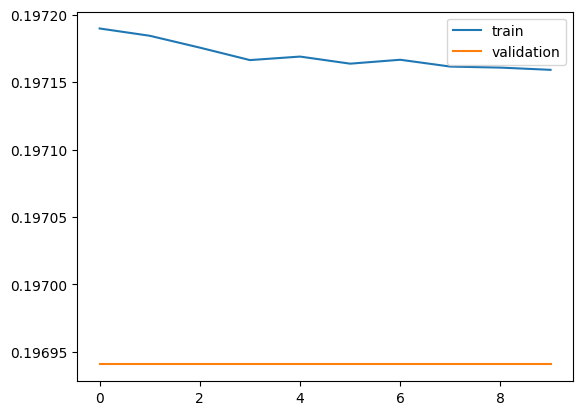

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

338/338 [==============================] - 60s 176ms/step - loss: 0.1971 - recall: 0.8029 - Accuracy: 0.8029 - precision: 0.8029


# **B. Bài tập**


1.   **Yêu cầu 1 (Tại lớp): Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.**
2.   **Yêu cầu 2 (Về nhà): Sinh viên chạy lại tập dữ liệu [CIC IDS 2018](https://www.unb.ca/cic/datasets/ids-2018.html) trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification.**





## *Yêu cầu 1*:

### Đọc dữ liệu

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path) 

2144903/2144903 [==============================] - 1s 0us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1) 
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

### Encode dữ liệu số và chữ

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-46-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-46-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-46-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [ ]:
df['protocol_type-tcp'].unique()

array([1, 0], dtype=uint8)

### Tiền xử lý

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:
# Sử dụng LabelEncoder để encode label cho bài toán multiclass
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(df["outcome"])
num_classes = len(label_encoder.classes_)
y = np_utils.to_categorical(encoded_y)

print(y[1])

In [ ]:
df.drop('outcome',axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

### Multiclass Classification

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Mô hình LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 23)                1495      
                                                                 
Total params: 18,391
Trainable params: 18,391
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=1024,
    validation_split=0.2, 
    shuffle = False
)

Epoch 1/10
271/271 [==============================] - 8s 21ms/step - loss: 0.0204 - accuracy: 0.6827 - val_loss: 0.0020 - val_accuracy: 0.9750
Epoch 2/10
271/271 [==============================] - 6s 20ms/step - loss: 0.0149 - accuracy: 0.7900 - val_loss: 0.0035 - val_accuracy: 0.9564
Epoch 3/10
271/271 [==============================] - 5s 18ms/step - loss: 0.0029 - accuracy: 0.9673 - val_loss: 0.0019 - val_accuracy: 0.9775
Epoch 4/10
271/271 [==============================] - 5s 19ms/step - loss: 0.0020 - accuracy: 0.9773 - val_loss: 0.0016 - val_accuracy: 0.9810
Epoch 5/10
271/271 [==============================] - 6s 20ms/step - loss: 0.0040 - accuracy: 0.9517 - val_loss: 0.0017 - val_accuracy: 0.9801
Epoch 6/10
271/271 [==============================] - 6s 22ms/step - loss: 0.0018 - accuracy: 0.9795 - val_loss: 0.0016 - val_accuracy: 0.9811
Epoch 7/10
271/271 [==============================] - 7s 25ms/step - loss: 0.0017 - accuracy: 0.9800 - val_loss: 0.0016 - val_accuracy: 0.9812

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, F1 score, and accuracy
# precision values for labels without predicted samples will be set to 0.0, allowing the calculation to proceed without raising an exception
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

4632/4632 [==============================] - 18s 4ms/step
Precision: 0.9940466809218108
Recall: 0.13385490715630197
F1 Score: 0.1319018252578612
Accuracy: 0.9702038365259401


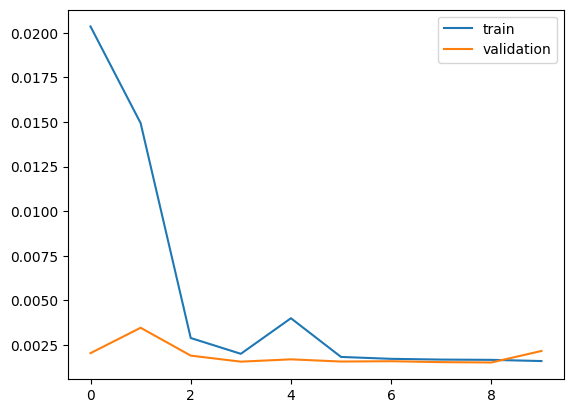

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## *Yêu cầu 2:*

### Đọc dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip awscliv2.zip
!./aws/install

Streaming output truncated to the last 5000 lines.
  inflating: aws/dist/awscli/examples/comprehendmedical/stop-phi-detection-job.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/list-snomedct-inference-jobs.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/detect-phi.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/describe-phi-detection-job.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/start-icd10-cm-inference-job.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/infer-icd10-cm.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/infer-rx-norm.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/stop-entities-detection-v2-job.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/start-snomedct-inference-job.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/describe-rx-norm-inference-job.rst  
  inflating: aws/dist/awscli/examples/comprehendmedical/start-phi-detection-job.rst  
  in

In [ ]:
!aws s3 sync --no-sign-request --region ap-southeast-1 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms" "/content/drive/MyDrive/ColabNotebooks/Lab05"

download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv to drive/MyDrive/ColabNotebooks/Lab05/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv to drive/MyDrive/ColabNotebooks/Lab05/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv to drive/MyDrive/ColabNotebooks/Lab05/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv to drive/MyDrive/ColabNotebooks/Lab05/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv to drive/MyDrive/ColabNotebooks/Lab05/Friday-02-

In [ ]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Lab05/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv", nrows=300000)
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,6,22/02/2018 08:26:03,20553406,10,7,1063,1297,744,0,...,20,1027304.0,0.0,1027304,1027304,1.952608e+07,0.000000e+00,19526080,19526080,Benign
1,34989,6,22/02/2018 08:26:24,790,2,0,848,0,848,0,...,20,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Benign
2,500,17,22/02/2018 08:25:10,99745913,5,0,2500,0,500,500,...,8,4000203.0,0.0,4000203,4000203,3.191524e+07,3.792787e+07,75584115,7200679,Benign
3,500,17,22/02/2018 08:25:10,99745913,5,0,2500,0,500,500,...,8,4000189.0,0.0,4000189,4000189,3.191524e+07,3.792788e+07,75584130,7200693,Benign
4,500,17,22/02/2018 08:24:59,89481361,6,0,3000,0,500,500,...,8,4000554.0,0.0,4000554,4000554,2.137020e+07,1.528109e+07,41990741,7200848,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,53,17,22/02/2018 10:58:08,1460,1,1,43,145,43,43,...,8,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Benign
299996,53,17,22/02/2018 11:00:49,900,1,1,50,78,50,50,...,8,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Benign
299997,53,17,22/02/2018 02:00:07,185760,2,2,70,248,35,35,...,8,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Benign
299998,53,17,22/02/2018 12:39:09,320,1,1,54,70,54,54,...,8,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Benign


### Xử lý dữ liệu

In [ ]:
def deleted_columns(dataset):
    col = dataset.columns
    num_val = []
    for column in col:
        num_val.append(len(dataset[column].unique()))

    col_df = pd.DataFrame({'Column': col, 'Distinct Value': num_val})
    single_cols = col_df[col_df['Distinct Value'] == 1]
    too_many_cols = col_df[col_df['Distinct Value'] > 10]
    return col_df, single_cols, too_many_cols

In [ ]:
# Xóa các cột chỉ có 1 giá trị hoặc có nhiều hơn 10 giá trị khác nhau
col_df, single_cols, too_many_cols = deleted_columns(df)
df = df.drop(columns= single_cols['Column'].values)
df = df.drop(columns= too_many_cols['Column'].values)

In [ ]:
df

,Protocol,Fwd PSH Flags,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Fwd Seg Size Min,Label
0,6,0,0,0,0,1,0,0,0,20,Benign
1,6,1,0,1,0,0,1,0,0,20,Benign
2,17,0,0,0,0,0,0,0,0,8,Benign
3,17,0,0,0,0,0,0,0,0,8,Benign
4,17,0,0,0,0,0,0,0,0,8,Benign
...,...,...,...,...,...,...,...,...,...,...,...
299995,17,0,0,0,0,0,0,0,0,8,Benign
299996,17,0,0,0,0,0,0,0,0,8,Benign
299997,17,0,0,0,0,0,0,0,0,8,Benign
299998,17,0,0,0,0,0,0,0,0,8,Benign


In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1) 
df.shape

(300000, 11)

In [ ]:
df.dtypes

Protocol             int64
Fwd PSH Flags        int64
FIN Flag Cnt         int64
SYN Flag Cnt         int64
RST Flag Cnt         int64
PSH Flag Cnt         int64
ACK Flag Cnt         int64
URG Flag Cnt         int64
ECE Flag Cnt         int64
Fwd Seg Size Min     int64
Label               object
dtype: object

In [ ]:
df.groupby('Label')['Label'].count()

Label
Benign              299638
Brute Force -Web       249
Brute Force -XSS        79
SQL Injection           34
Name: Label, dtype: int64

### Encode dữ liệu số và chữ

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
text_col = []
# Lựa chọn các cột có giá trị không phải kiểu int hoặc kiểu float 
for i in range(df.shape[1]):
  if str(df.dtypes[i]) != "int64" and str(df.dtypes[i]) != "float64":
    if str(df.columns[i]) != "Label":
      text_col.append(df.columns[i])

In [ ]:
#encoding feature vector
for i in df.columns:
  if i not in text_col:
    if i != 'Label':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,Protocol,Fwd PSH Flags,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Fwd Seg Size Min,Label
0,-0.588705,-0.204858,-0.073752,-0.204858,-0.375893,1.268377,-0.683546,-0.204902,-0.375888,0.619528,Benign
1,-0.588705,4.881413,-0.073752,4.881413,-0.375893,-0.788406,1.462955,-0.204902,-0.375888,0.619528,Benign
2,1.589546,-0.204858,-0.073752,-0.204858,-0.375893,-0.788406,-0.683546,-0.204902,-0.375888,-1.434240,Benign
3,1.589546,-0.204858,-0.073752,-0.204858,-0.375893,-0.788406,-0.683546,-0.204902,-0.375888,-1.434240,Benign
4,1.589546,-0.204858,-0.073752,-0.204858,-0.375893,-0.788406,-0.683546,-0.204902,-0.375888,-1.434240,Benign


### Binary class

In [ ]:
normal_mask = df['Label']=='Benign'
attack_mask = df['Label']!='Benign'

df.drop('Label',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 299638
Attack count: 362


In [ ]:
# feature vector
X_nor = df_normal.values
X_att = df_attack.values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_nor, test_size=0.3, random_state=12)

In [ ]:
X_train.shape, X_test.shape

((209746, 10), (89892, 10))

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_nor = sc.fit_transform(X_nor)
X_att = sc.fit_transform(X_att)

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_att = pd.DataFrame(X_att)
X_nor = pd.DataFrame(X_nor)

In [ ]:
#Hàm convert time domain dữ liệu
def create_dataset(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [ ]:
# reshape [samples, time_steps, n_features]

TIME_STEPS = 1
x_train = create_dataset(X_train, TIME_STEPS)
print(x_train.shape)

(209745, 1, 10)


In [ ]:
x_test = create_dataset(X_test, TIME_STEPS)
print(x_test.shape)

(89891, 1, 10)


In [ ]:
x_nor = create_dataset(X_nor, TIME_STEPS)
x_att = create_dataset(X_att, TIME_STEPS)
print(x_nor.shape , x_att.shape)

(299637, 1, 10) (361, 1, 10)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Khởi tạo mô hình
model = keras.Sequential()
# Thêm lớp LSTM vào mô hình
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1], x_train.shape[2])))
# Thêm lớp Dropout vào mô hình (Dropout giúp ngăn chặn overfitting bằng cách 
# loại bỏ ngẫu nhiên một phần các đơn vị đầu vào trong quá trình huấn luyện.)
model.add(keras.layers.Dropout(rate=0.5))
# Lặp lại đầu ra từ lớp LSTM
model.add(keras.layers.RepeatVector(n=x_train.shape[1]))

# Tương tự, thêm một lớp LSTM và Dropout
model.add(keras.layers.LSTM(units=32, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.4))
# Thêm một lớp Dense vào mô hình
# Lớp TimeDistributed giúp mô hình áp dụng các trọng số chia sẻ từ lớp Dense cho tất cả các bước thời gian trong chuỗi
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=x_train.shape[2])))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 dropout_1 (Dropout)         (None, 1, 32)             0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 10)            330       
 ibuted)                                                

In [ ]:
history = model.fit(
    x_train, x_train,
    epochs=2,
    batch_size=120,
    validation_split=0.2, 
    shuffle = False
)


Epoch 1/2
1399/1399 [==============================] - 22s 9ms/step - loss: 0.2140 - accuracy: 0.7909 - val_loss: 0.0968 - val_accuracy: 0.8923
Epoch 2/2
1399/1399 [==============================] - 13s 10ms/step - loss: 0.1586 - accuracy: 0.8193 - val_loss: 0.0930 - val_accuracy: 0.7701


In [ ]:
x_pred = model.predict(x_test)
x_pred_binary = np.argmax(x_pred, axis=1)
x_true_binary = np.argmax(x_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(x_true_binary, x_pred_binary, average='macro', zero_division=0.0)
recall = recall_score(x_true_binary, x_pred_binary, average='macro', zero_division=0.0)
f1 = f1_score(x_true_binary, x_pred_binary, average='macro', zero_division=0.0)
accuracy = accuracy_score(x_true_binary, x_pred_binary)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

2810/2810 [==============================] - 8s 3ms/step
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 1.0


### Multi class

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# Sử dụng LabelEncoder để encode label cho bài toán multiclass
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(df["Label"])
num_classes = len(label_encoder.classes_)
y = np_utils.to_categorical(encoded_y)

print(y[1])

[1. 0. 0. 0.]


In [ ]:
df.drop('Label',axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((210000, 10), (210000, 4))
Normal test count: ((90000, 10), (90000, 4))


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Mô hình LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,156
Trainable params: 17,156
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=1024,
    validation_split=0.2, 
    shuffle = False
)

Epoch 1/10
165/165 [==============================] - 3s 8ms/step - loss: 0.0546 - accuracy: 0.9673 - val_loss: 5.7173e-04 - val_accuracy: 0.9989
Epoch 2/10
165/165 [==============================] - 1s 5ms/step - loss: 8.3441e-04 - accuracy: 0.9989 - val_loss: 5.7150e-04 - val_accuracy: 0.9989
Epoch 3/10
165/165 [==============================] - 1s 7ms/step - loss: 7.1878e-04 - accuracy: 0.9989 - val_loss: 5.7144e-04 - val_accuracy: 0.9989
Epoch 4/10
165/165 [==============================] - 1s 7ms/step - loss: 6.7990e-04 - accuracy: 0.9989 - val_loss: 5.7144e-04 - val_accuracy: 0.9989
Epoch 5/10
165/165 [==============================] - 1s 7ms/step - loss: 6.4764e-04 - accuracy: 0.9989 - val_loss: 5.7143e-04 - val_accuracy: 0.9989
Epoch 6/10
165/165 [==============================] - 1s 6ms/step - loss: 6.3687e-04 - accuracy: 0.9989 - val_loss: 5.7143e-04 - val_accuracy: 0.9989
Epoch 7/10
165/165 [==============================] - 1s 6ms/step - loss: 6.2713e-04 - accuracy: 0.9989 

In [ ]:
x_pred = model.predict(x_test)
x_pred_binary = np.argmax(x_pred, axis=1)
x_true_binary = np.argmax(y_test, axis=1)  # Assuming y_test contains the true labels

# Calculate precision, recall, and F1 score
precision = precision_score(x_true_binary, x_pred_binary, average='macro', zero_division=0.0)
recall = recall_score(x_true_binary, x_pred_binary, average='macro', zero_division=0.0)
f1 = f1_score(x_true_binary, x_pred_binary, average='macro', zero_division=0.0)
accuracy = accuracy_score(x_true_binary, x_pred_binary)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

2813/2813 [==============================] - 7s 3ms/step
Precision: 0.2496611111111111
Recall: 0.25
F1 Score: 0.2498304406319839
Accuracy: 0.9986444444444444
